In [ ]:
from google.colab import userdata
!pip install -qU "langchain-community>=0.2.11" tavily-python
key = userdata.get('TAVILY_API_KEY')
import subprocess
import os

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = key
def check_and_install(package_name):
    try:
        subprocess.check_output(['pip', 'show', package_name])
    except subprocess.CalledProcessError:
        print(f"{package_name} not found, installing...")
        subprocess.check_output(['pip', 'install', package_name])
    else:
        print(f"{package_name} already installed.")

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')

check_and_install('langchain_community')
check_and_install('langchain')
check_and_install('openai')
check_and_install('python-dotenv')
check_and_install('tiktoken')
check_and_install('langchain_openai')
check_and_install('google-colab')
check_and_install('langgraph')
check_and_install('chromadb')
check_and_install('langchain_experimental')
!pip install --upgrade langchain
!pip install langgraph
!pip install chromadb
!pip install -U pydantic

oai_key = userdata.get('OPENAI_API_KEY')

Running on CoLab
langchain_community already installed.
langchain already installed.
openai already installed.
python-dotenv already installed.
tiktoken already installed.
langchain_openai already installed.
google-colab already installed.
langgraph already installed.
chromadb already installed.
langchain_experimental already installed.


In [ ]:
from pydantic import BaseModel, Field, validator, model_validator
from typing import Dict, Optional
from langchain_core.language_models.chat_models import BaseChatModel
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt.chat_agent_executor import AgentState
from langchain_core.runnables.config import RunnableConfig
import uuid
from typing import Annotated, List, Optional, OrderedDict, Tuple, Union
from langchain.prompts import PromptTemplate




class CleaningMetadata(BaseModel):
    """Metadata about the data cleaning actions taken."""
    steps_taken: list[str] = Field(description="List of cleaning steps performed.")
    data_description_after_cleaning: str = Field(description="Brief description of the dataset after cleaning.")


class InitialDescription(BaseModel):
    """Initial description of the dataset."""
    dataset_description: str = Field(description="Brief description of the dataset.")
    data_sample: Optional[str] = Field(description="Sample of the data (first few rows).")

class AnalysisInsights(BaseModel):
    """Insights from the exploratory data analysis."""
    summary: str = Field(description="Overall summary of EDA findings.")
    correlation_insights: str = Field(description="Key correlation insights identified.")
    anomaly_insights: str = Field(description="Anomalies or interesting patterns detected.")
    recommended_visualizations: list[str] = Field(description="List of recommended visualizations to illustrate findings.")



class VisualizationResults(BaseModel):
    """Results from the visualization generation."""
    visualizations: List[
        dict
    ] = Field(
        description="List of visualizations generated. Each dictionary should have the plot type and the base64 encoded image"
    )
    # visualizations: Optional[str] = Field(description="Visualization Results")

# Define the ReportResults class
class ReportResults(BaseModel):
    """Results from the report generation."""
    report_path: str = Field(description="Path to the generated report file.")
    # Add other fields as needed, e.g., for different report formats


class DataQueryParams(BaseModel):
    """
Parameters for querying the DataFrame.

Attributes:
  columns: List[str] - List of columns to include in the output.
  filter_column: Optional[str] - Column to apply the filter on.
  filter_value: Optional[str] - Value to filter the rows by.
  operation: str - Operation to perform.

    """
    columns: List[str] = Field(..., description="List of columns to include in the output")
    filter_column: Optional[str] = Field(None, description="Column to apply the filter on")
    filter_value: Optional[str] = Field(None, description="Value to filter the rows by")
    operation: str = Field("select", description="Operation to perform: 'select', 'sum', 'mean', 'count', 'max', 'min', 'median', etc.")


schema_extra_cols={
            "anyOf": [
                {"type": "integer"},
                {"type": "array", "items": {"type": "integer"}},
                {"type": "array", "items": {"type": "integer"}, "minItems": 2, "maxItems": 2},
            ]
        }

schema_extra_cells={
            "anyOf": [
                {"type": "array", "items": {"type": "integer"}, "minItems": 2, "maxItems": 2},
                {"type": "null"},
            ]
        }

class GetDataParams(BaseModel):
    """
Parameters for retrieving data from the DataFrame.

Attributes:
  df_id: DataFrame ID in the global registry (as a string)
  index: (as `Union[int, List[int], Tuple[int, int]]`) Can be: An integer (single row), a list of integers (multiple rows), or a tuple (start, end) for a row range.
  columns: A string (single column), a list of strings (multiple columns), or "all" for all columns (default: "all").
  cells: A list of (row_index, column_name) tuples to retrieve specific cell values (as `Optional[List[Tuple[int, str]]]`).
    """
    df_id: str = Field(..., description="DataFrame ID in the global registry.")
    index: Union[int, List[int], Tuple[int, int]] = Field(..., description="An integer (single row), a list of integers (multiple rows), or a tuple (start, end) for a row range.", json_schema_extra=schema_extra_cols)
    columns: Union[str, List[str]] = Field("all", description="A string (single column), a list of strings (multiple columns), or 'all' for all columns (default: 'all').")
    cells: Optional[List[Tuple[int, str]]] = Field(None, description="A list of (row_index, column_name) tuples to retrieve specific cell values.",json_schema_extra={
            "type": "array",  # Specify it's an array
            "items": {  # Define the schema for items within the array
                "type": "array",  # Each item is an array (tuple)
                "items": [
                    {"type": "integer"},  # First element of the tuple is an integer (row_index)
                    {"type": "string"},  # Second element is a string (column_name)
                ],
                "minItems": 2,  # Enforce tuple length
                "maxItems": 2,
            },
        },)

    @model_validator(mode='before')
    def validate_index(cls, values):
        """Validate and transform the 'index' field."""
        index = values.get('index')
        if not isinstance(index, (int, list, tuple)):
            raise ValueError("Invalid 'index' type. Must be int, list, or tuple.")
        if isinstance(index, tuple) and len(index) != 2:
            raise ValueError("Invalid tuple length for 'index'. Must be a 2-tuple for range.")
        if isinstance(index, list) and not all(isinstance(i, int) for i in index):
            raise ValueError("Invalid list elements for 'index'. Must contain only integers.")

        # if isinstance(index, int):
        #     values["index"] = [index]
        return values

class DataFrameRegistry:
    def __init__(self, capacity=20):
        self.registry: Dict[str, dict] = {}  # Changed from Dict[str, pd.DataFrame] to Dict[str, dict]
        self.df_id_to_raw_path: Dict[str, str] = {}
        self.cache = OrderedDict()  # Use OrderedDict for LRU cache
        self.capacity = capacity

    def register_dataframe(self, df=None, df_id=None, raw_path=""):
        if df_id is None:
            df_id = str(uuid.uuid4())
        if raw_path == "":
            raw_path = WORKING_DIRECTORY / f"{df_id}.csv"
        self.registry[df_id] = {"df": df, "raw_path": raw_path}
        self.df_id_to_raw_path[df_id] = raw_path
        if df is not None:  # Add to cache if DataFrame is provided
            self.cache[df_id] = df
            if len(self.cache) > self.capacity:
                self.cache.popitem(last=False)
        return df_id

    def get_dataframe(self, df_id: str, load_if_not_exists=False):
        if df_id in self.cache:
            # Move the accessed DataFrame to the end of the OrderedDict
            self.cache.move_to_end(df_id)
            return self.cache[df_id]
        # If not in cache, load from registry or file
        df = super().get_dataframe(df_id, load_if_not_exists)
        if df:
            # Add the loaded DataFrame to the cache
            self.cache[df_id] = df
            # If cache exceeds capacity, evict the LRU entry
            if len(self.cache) > self.capacity:
                self.cache.popitem(last=False)  # Remove from the beginning
        return df
    def remove_dataframe(self, df_id: str):
        if df_id in self.registry:
            del self.registry[df_id]
            if df_id in self.cache:
                del self.cache[df_id]
            del self.df_id_to_raw_path[df_id]
    def get_raw_path_from_id(self, df_id: str):
        return self.df_id_to_raw_path.get(df_id)

global_df_registry = DataFrameRegistry()

class State(AgentState):
  next: str
  user_prompt: str
  df_ids: List[str] = Field(default_factory=list) # Use a list to store df_ids
  _config: Optional[RunnableConfig] = None
  initial_description: Optional[InitialDescription] = None
  cleaning_metadata: Optional[CleaningMetadata] = None
  analysis_insights: Optional[AnalysisInsights] = None
  initial_analysis_agent: Optional[BaseChatModel] = None
  data_cleaner_agent: Optional[BaseChatModel] = None
  analyst_agent: Optional[BaseChatModel] = None
  initial_analysis_complete: Optional[bool] = False
  data_cleaning_complete: Optional[bool] = False
  analyst_complete: Optional[bool] = False
  file_writer_complete: Optional[bool] = False
  _count_: int = 0
  _id_: str = Field(default_factory=lambda: str(uuid.uuid4()))
  visualization_results: Optional[VisualizationResults] = None
  visualization_complete: Optional[bool] = False
  report_results: Optional[ReportResults] = None
  report_generator_complete: Optional[bool] = False

# class AState(AgentState):
#   next: str
#   user_prompt: str
#   initial_description: Optional[InitialDescription] = None
#   cleaning_metadata: Optional[CleaningMetadata] = None
#   analysis_insights: Optional[AnalysisInsights] = None

data_cleaner_prompt_template = PromptTemplate(
    input_variables=['dataset_description', 'data_sample', 'tool_descriptions', 'output_format', 'available_df_ids'],
    template="""You are a Data Cleaner Agent equipped with tools to clean and preprocess a dataset.
    The df_ids you can use to access the data are: {available_df_ids}

    Here's a description of the dataset: {dataset_description}
    Here's a sample of the data (first few rows):
    {data_sample}

    Your available tools are:
    {tool_descriptions}

    You have access to a tool called `query_dataframe` for querying the DataFrame.
    Refer to the tool's docstring for detailed usage instructions and examples.
    You can get the column names with `get_column_names`, and get any specified data from the dataframe using `get_data`.

    Identify potential issues like missing values, outliers, incorrect data types, and inconsistencies.
    Propose and execute a cleaning strategy, step-by-step, using the provided tools.
    For each step, clearly state the tool you are using and the parameters.
    Explain your reasoning for each cleaning step.

    Example Plan & Execution:
    Step 1: Check for missing values in each column using the 'CheckMissingValues' tool with input 'df_id'.
    Step 2: If 'Age' column has missing values, fill them using the 'FillMissingMedian' tool with input 'df_id' and 'column_name' as 'Age'.
    ... and so on.

    After cleaning, summarize the actions taken and describe the current state of the dataset in a structured JSON format following this schema:
    {output_format}

    Let's begin! What is your data cleaning plan and execution using tools, and structured output?
    """,
)

<ipython-input-2-2435ff6d357e>:108: PydanticDeprecatedSince20: Pydantic V1 style `@root_validator` validators are deprecated. You should migrate to Pydantic V2 style `@model_validator` validators, see the migration guide for more details. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  @root_validator(pre=True)


In [ ]:

analyst_prompt_template_initial = PromptTemplate(
    input_variables=['user_prompt', 'tool_descriptions', 'output_format','available_df_ids'],
    template="""You are an Data Describer and Sampler. Your role is to perform exploratory data analysis (EDA) on a dataset.
    Here's a text description of the dataset: {user_prompt}

    First, we need a basic description of the dataset, along with a sample of the data, to pass to the Data Cleaner Agent.

    The df_ids you can use to access the data are: {available_df_ids}


    Your available tools are:
    {tool_descriptions}


    Describe the dataset in a structured JSON format following this schema:
    {output_format}
    FIRST, think of a step by step plan for how to proceed with collecting the data you need, when to stop collecting, and how and when to report back in the requested format.

    Using your tools in a conservative manner, please 1. Write a text description of the dataset based on a few strategically used tool calls, and write it to dataset_description attribute.
    Then, 2. use your tools to produce a sample of the data for the data_sample attribute.

    Do not make unnecessary or repeated tool calls! Report straight to the Supervisor with the expected output format.

    After performing any necessary tool calls, IMMEDIATELY output your final answer in the specified format. Do NOT make any further tool calls!
    You do not need to perform the functions of other agents, do your job and submit the results.
    """,
)

analyst_prompt_template_main = PromptTemplate(
    input_variables=['cleaned_dataset_description', 'cleaning_metadata', 'tool_descriptions', 'output_format','available_df_ids'],
    template="""You are an Analyst Agent. Your role is to perform exploratory data analysis (EDA) on a cleaned dataset.
    Here's a description of the cleaned dataset: {cleaned_dataset_description}
    Here's metadata about the data cleaning actions taken: {cleaning_metadata}

    Your available tools are:
    {tool_descriptions}

    The df_ids you can use to access the data are: {available_df_ids}

    You have access to a tool called `query_dataframe` for querying the DataFrame.
    Refer to the tool's docstring for detailed usage instructions and examples.
    You can get the column names with `get_column_names`, and get any specified data from the dataframe using `get_data`.

    Perform EDA to understand the dataset. Include:
    - Descriptive statistics (mean, median, mode, standard deviation, etc.) for relevant columns.
    - Identify potential correlations between features.
    - Highlight any anomalies or interesting patterns you find.
    - Reason step-by-step about your analysis (Chain-of-Thought).
    - Recommend visualizations that would best illustrate your findings.

    Output should be a summary of your EDA findings, insights, and recommended visualizations, based on your tool usage, all written into the
    {output_format} class.

    Let's begin! What are your EDA insights and visualization recommendations using tools?

    """,
)


file_writer_prompt_template = PromptTemplate(
    input_variables=['file_name', 'content', 'file_type','tool_descriptions','available_df_ids'],
    template= """You are an agent that specializes in writing data to a file in the format of {file_type}. You are one member of a data analysis team. You ONLY write content as requested in a analyst-friendly manner. Leaver other tasks to other agents on the team.
    You have the following tools at your disposal:
    {tool_descriptions}

    The df_ids you can use to access the data are: {available_df_ids}


    Write the following content to a file named {file_name}:
    {content}
    """,
)
visualization_prompt_template = PromptTemplate(
    input_variables=[
        "cleaned_dataset_description",
        "analysis_insights",
        "tool_descriptions",
        "output_format",
        "available_df_ids",
    ],
    template="""You are a Visualization Agent equipped with tools to create visualizations.
    Here's a description of the cleaned dataset: {cleaned_dataset_description}
    Here are the insights from the Analyst Agent and the list of visualizations to create: {analysis_insights}

    Your available tools are:
    {tool_descriptions}

    The df_ids you can use to access the data are: {available_df_ids}


    Create the visualizations step-by-step, using the provided tools.
    For each step, clearly state the tool you are using and the parameters.
    Explain your reasoning for each visualization.

    After creating the visualizations, summarize the actions taken and describe the current state of the visualizations in a structured JSON format following this schema:
    {output_format}

    Let's begin!
    What is your visualization plan and execution using tools, and structured output?
    """,
)
report_generator_prompt_template = PromptTemplate(
    input_variables=[
        "cleaning_metadata",
        "analysis_insights",
        "visualization_results",
        "tool_descriptions",
        "output_format",
        "available_df_ids",
    ],
    template="""You are a Report Generator Agent equipped with tools to generate reports.
    Here's the metadata about the data cleaning actions taken: {cleaning_metadata}
    Here are the insights from the Analyst Agent: {analysis_insights}
    Here are the visualization results: {visualization_results}

    Your available tools are:
    {tool_descriptions}

    The df_ids you can use to access the data are: {available_df_ids}

    Generate a structured report that combines textual explanations, statistics, and visualizations.
    Explain your reasoning for the report structure.

    After generating the report, summarize the actions taken and describe the current state of the report in a structured JSON format following this schema:
    {output_format}

    Let's begin!
    What is your report generation plan and execution using tools, and structured output?
    """,
)


In [ ]:
from langchain_core.tools import tool, InjectedToolArg
from langchain.tools import Tool
from tempfile import TemporaryDirectory
from pathlib import Path
import pandas as pd
import io
from typing import Dict, List, Tuple, Optional, Union

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

@tool(name_or_callable="GetDataframeSchema",response_format="content_and_artifact")
def get_dataframe_schema() -> tuple[str, dict]:
    """
    Return a summary of the DataFrame's schema and sample data.

    Returns:
        A tuple containing a summary of the DataFrame's schema and sample data.

    """
    try:
        schema = {
            "columns": list(df.columns),
            "dtypes": df.dtypes.astype(str).to_dict(),
            "sample": df.head(3).to_dict(orient="records")
        }
        return "", {"schema": schema}
    except Exception as e:
        return f"Error: {str(e)}", {}

@tool("GetColumnNames")
def get_column_names(df_id: str) -> str:
    """Useful to get the names of the columns in the current DataFrame.

    Retrieves the names of all columns in the DataFrame.

    Args:
        df_id: The ID of the DataFrame in the global registry.

    Returns:
        A comma-separated string of column names.

    Example:
        If the DataFrame has columns 'Name', 'Age', and 'City', the output would be:
        "Name, Age, City"
    """
    print(f"Getting column names from {df_id}/n")
    df = global_df_registry.get_dataframe(df_id)
    if df is None:
      try:
        raw_path = global_df_registry.get_raw_path_from_id(df_id)
        df = pd.read_csv(raw_path)
        global_df_registry.register_dataframe(df, df_id, raw_path)
      except Exception as e:
        return f"Error loading DataFrame: {e}"
      pass
    pprint(f"Column names: {', '.join(df.columns.tolist())} /n")
    return ", ".join(df.columns.tolist())

@tool("CheckMissingValues")
def check_missing_values(df_id: str) -> str:
    """Checks for missing values in a pandas DataFrame and returns a summary.

    Checks for missing values in the DataFrame.

    Args:
        df_id: The ID of the DataFrame in the global registry.

    Returns:
        A summary of missing values in each column.
    """
    pprint(f"Checking missing values in {df_id}")
    df = global_df_registry.get_dataframe(df_id)

    if df is None:
      try:
        raw_path = global_df_registry.get_raw_path_from_id(df_id)
        df = pd.read_csv(raw_path)
        global_df_registry.register_dataframe(df, df_id, raw_path)
      except Exception as e:
        return f"Error loading DataFrame: {e}"
      pass

    missing_values = df.isnull().sum()
    pprint(f"Missing values: {missing_values}")
    return missing_values.to_string()

@tool("DropColumn")
def drop_column(df_id: str, column_name: str) -> str:
    """
    Drops a specified column from the DataFrame.

    Args:
        df_id: The ID of the DataFrame in the global registry.
        column_name: The name of the column to drop.

    Returns:
        A message indicating whether the column was dropped successfully.
    """
    pprint(f"Dropping column {column_name} from {df_id}")
    df = global_df_registry.get_dataframe(df_id)

    try:
        if df is None:
          try:
            raw_path = global_df_registry.get_raw_path_from_id(df_id)
            df = pd.read_csv(raw_path)
            global_df_registry.register_dataframe(df, df_id, raw_path)
          except Exception as e:
            return f"Error loading DataFrame: {e}"
          pass
        df_dropped = df.drop(columns=[column_name])
        return "Column dropped successfully. New columns: " + ", ".join(df_dropped.columns.tolist())
    except Exception as e:
        return f"Error dropping column: {e}"


@tool
def delete_rows(df_id: str, conditions: Union[str, List[str], Dict], inplace: bool = True) -> str:
    """
    Deletes rows from the DataFrame based on specified conditions.

    Args:
        df_id: The ID of the DataFrame in the global registry.
        conditions: The conditions for deleting rows. Can be a string, a list of strings, or a dictionary.
        inplace: Whether to delete rows inplace or return a new DataFrame. Defaults to True.

    Returns:
        A message indicating the result of the operation.

    Examples:
        * Delete rows where 'Age' is greater than 30:
        ```python
        delete_rows(df_id='my_df', conditions='Age > 30')
        ```
        * Delete rows where 'Age' is greater than 30 and 'Gender' is Female:
        ```python
        delete_rows(df_id='my_df', conditions={"and": ["Age > 30", "Gender == 'Female'"]})
        ```

    """
    try:
        df = global_df_registry.get_dataframe(df_id)
        if df is None:
          try:
            raw_path = global_df_registry.get_raw_path_from_id(df_id)
            df = pd.read_csv(raw_path)
            global_df_registry.register_dataframe(df, df_id, raw_path)
          except Exception as e:
            return f"Error loading DataFrame: {e}"
          pass

        if isinstance(conditions, str):
            conditions = [conditions]

        if isinstance(conditions, list):
            for condition in conditions:
                df = df.query(condition)
        elif isinstance(conditions, dict):
            #Gemini, please write the logic to handle dictionary conditions:
            for condition_type, condition_list in conditions.items():
                if condition_type == "and":
                    for condition in condition_list:
                        df = df.query(condition)
                        pass
                elif condition_type == "or":
                    for condition in condition_list:
                        df = df.query(condition)
                    pass
                elif condition_type == "not":
                    for condition in condition_list:
                        df = df.query(condition)
                    pass
                else:
                    return "Error: Invalid condition type."


            pass
        else:
            return "Error: Invalid conditions format."

        if inplace:
            df.drop(df.index, inplace=True)
            return "Rows deleted successfully."
        else:
            return df.to_json()  # Or return a summary

    except Exception as e:
        return f"Error deleting rows: {e}"


@tool("FillMissingMedian")
def fill_missing_median(df_id: str, column_name: str) -> str:
    """
    Fills missing values in a specified column with the median.

    Args:
        df_id: The ID of the DataFrame in the global registry.
        column_name: The name of the column to fill.

    Returns:
        A message indicating the result of the operation.
    """
    pprint(f"Filling missing values in column {column_name} from {df_id}")
    df = global_df_registry.get_dataframe(df_id)

    try:
      if df is None:
        try:
          raw_path = global_df_registry.get_raw_path_from_id(df_id)
          df = pd.read_csv(raw_path)
          global_df_registry.register_dataframe(df, df_id, raw_path)
        except Exception as e:
          return f"Error loading DataFrame: {e}"
        pass
      median_value = df[column_name].median()
      df_filled = df[column_name].fillna(median_value) # Only fill series for brevity
      return f"Missing values in column '{column_name}' filled with median: {median_value}."
    except Exception as e:
        return f"Error filling missing values: {e}"



# Define tools as LangChain Tools
data_cleaning_tools = [
    Tool(
        name="GetDataFrameSchema",
        func=get_dataframe_schema,
        description="Useful to get a summary of the DataFrame's schema and sample data.",
    ),
    Tool(
        name="GetColumnNames",
        func=get_column_names,
        description="Useful to get the names of the columns in the current DataFrame. Input should be 'df_id'.",
    ),
    Tool(
        name="CheckMissingValues",
        func=check_missing_values,
        description="Useful to check for missing values in the DataFrame. Input should be 'df_id'.",
    ),
    Tool(
        name="DropColumn",
        func=drop_column,
        description="Useful to drop a column from the DataFrame. Input should be 'df_id' and 'column_name'.",
    ),
    Tool(
        name="DeleteRows",
        func=delete_rows,
        description="Useful to delete rows from the DataFrame based on specified conditions. Input should be 'df_id', 'conditions', and 'inplace'.",
    ),
    Tool(
        name="FillMissingMedian",
        func=fill_missing_median,
        description="Useful to fill missing values in a specific column using the median. Input should be 'df_id' and 'column_name'.",
    ),

]

In [ ]:
import pandas as pd
import io
from scipy import stats
import numpy as np
from sklearn.cluster import KMeans # Example - if you want to include sklearn



from typing import Union, Tuple


from langchain.agents import tool

@tool(name_or_callable="QueryDataframe",response_format="content_and_artifact")
def query_dataframe(params: DataQueryParams, df_id: str) -> tuple[str, dict]:
    """
    Query the DataFrame based on specified columns, filter, and operation.

    Use the `query_dataframe` tool effectively to explore and analyze the data.
    Remember to provide the correct `df_id` when using the tool.

    Args:
        params: A DataQueryParams object defining the query.
        df_id: The ID of the DataFrame in the global registry.

    Returns:
        A tuple containing a status message and a dictionary with the query result as a JSON artifact.

    Examples:
        * Select specific columns:
        ```python
        params = DataQueryParams(columns=["Name", "Age"])
        result = query_dataframe(params, df_id)
        ```

        * Filter rows based on a condition:
        ```python
        params = DataQueryParams(columns=["Sales"], filter_column="Region", filter_value="North")
        result = query_dataframe(params, df_id)
        ```

        * Calculate the sum of a column:
        ```python
        params = DataQueryParams(columns=["Sales"], operation="sum")
        result = query_dataframe(params, df_id)
        ```

        * Calculate the mean of a column for a specific group:
        ```python
        params = DataQueryParams(columns=["Salary"], filter_column="Department", filter_value="Marketing", operation="mean")
        result = query_dataframe(params, df_id)
        ```
    """
    try:
        df = global_df_registry.get_dataframe(df_id)
        if df is None:
            try:
              raw_path = global_df_registry.get_raw_path_from_id(df_id)
              df = pd.read_csv(raw_path)
              global_df_registry.register_dataframe(df, df_id, raw_path, raw_path)
            except Exception as e:
                return f"Error loading DataFrame: {e}"
            pass

        # Validate the column exists
        if params.filter_column and params.filter_column not in df.columns:
            return "Error: Filter column does not exist.", {}

        # Filter the DataFrame
        if params.filter_column:
            filtered_df = df[df[params.filter_column] == params.filter_value]
        else:
            filtered_df = df

        # Perform the operation
        if params.operation == "select":
            result = filtered_df[params.columns].to_dict(orient="records")
        elif params.operation == "sum":
            result = filtered_df[params.columns].sum(numeric_only=True).to_dict()
        elif params.operation == "mean":
            result = filtered_df[params.columns].mean(numeric_only=True).to_dict()
        elif params.operation == "count":
            result = filtered_df[params.columns].count().to_dict()
        else:
            return f"Unsupported operation: {params.operation}", {}

        return "Query successful.", {"result": result}

    except Exception as e:
        return f"Error: {str(e)}", {}

('properties', 'index', 'anyOf', '2')


@tool(name_or_callable="GetData", response_format="content_and_artifact")
def get_data(
params: GetDataParams, df_id: str = ""
) -> str:
    """
Retrieves data from a DataFrame by ID, for flexible row/column selection and retrieval specific cells.
Args:
  params: A GetDataParams object defining the query.
  df_id: The ID of the DataFrame in the global registry. Can be skipped since it is provided in the params.
Returns:
  A formatted string of the retrieved data with column names and values.

Example Usage:
# Get the 3rd row and columns 'Name' and 'Age'
get_data(GetDataParams(df_id='my_df', index=2, columns=['Name', 'Age'])

# Get rows with indices 1, 3, and 5, and all columns
get_data(GetDataParams(df_id='my_df', index=[1, 3, 5]))

# Get rows with indices from 10 to 20, and columns 'City' and 'Country'
get_data(GetDataParams(df_id='my_df', index=(10, 20), columns=['City', 'Country'])

# Get specific cell values
get_data(df_id='my_df', cells=[(1,'Name'),(5,'Age'),(10,'City')])
    """
    if df_id is None or df_id == "":
      df_id = params.df_id
    elif df_id.strip() != params.df_id.strip():
      return "Error: df_id mismatch."
    index = params.index
    columns = params.columns
    cells = params.cells
    df = global_df_registry.get_dataframe(df_id)
    if df is None:
        try:
          raw_path = global_df_registry.get_raw_path_from_id(df_id)
          df = pd.read_csv(raw_path)
          global_df_registry.register_dataframe(df, df_id, raw_path)
        except Exception as e:
            return f"Error loading DataFrame: {e}"
        pass

    if cells is not None:
        # Retrieve specific cell values
        output_str = ""
        for row_index, col_name in cells:
            val = df.loc[row_index, col_name]
            output_str += f"Value at ({row_index}, {col_name}): {val}\n"
        return output_str

    if isinstance(index, int):
        rows = df.loc[[index]]  # Single row
    elif isinstance(index, list):
        rows = df.loc[index]  # List of rows
    elif isinstance(index, tuple):
        rows = df.loc[index:index]  # Range of rows
    else:
        return "Error: Invalid index format."

    if columns == "all":
        columns_to_include = df.columns
    elif isinstance(columns, str):
        columns_to_include = [columns]
    elif isinstance(columns, list):
        columns_to_include = columns
    else:
        return "Error: Invalid columns format."

    selected_data = rows[columns_to_include]

    # Format the output string
    output_str = ""
    for row_index, row_data in selected_data.iterrows():
        output_str += f"Row {row_index}:\n"
        for col, val in row_data.items():
            output_str += f"  {col}: {val}\n"
    return output_str

@tool("GetDescriptiveStatistics")
def get_descriptive_statistics(df_id: str, column_names: str = "all") -> str:
    """
    Input should be 'df_id' and optionally 'column_names' (comma-separated string).
    If 'column_names' is 'all' or not provided, statistics for all columns are returned.

    Calculates descriptive statistics for specified columns in the DataFrame.

    Args:
        df_id: The ID of the DataFrame in the global registry.
        column_names: A comma-separated string of column names to analyze.
                      Defaults to "all", which analyzes all columns.

    Returns:
        A string representation of the descriptive statistics table.

    Example:
        get_descriptive_statistics(df_id='my_df', column_names='Age, Income')
        would return descriptive statistics for the 'Age' and 'Income' columns.

    """
    pprint(f"Getting descriptive statistics for {column_names} from {df_id}")
    df = global_df_registry.get_dataframe(df_id)

    try:
      if df is None:
        try:
          raw_path = global_df_registry.get_raw_path_from_id(df_id)
          df = pd.read_csv(raw_path)
          global_df_registry.register_dataframe(df, df_id, raw_path)
        except Exception as e:
          return f"Error loading DataFrame: {e}"
        pass
      columns_to_describe = df.columns if column_names.lower() == 'all' or not column_names else column_names.split(',')
      desc_stats = df[columns_to_describe].describe()
      return desc_stats.to_string()
    except Exception as e:
        return f"Error calculating descriptive statistics: {e}"

@tool("CalculateCorrelation")
def calculate_correlation(df_id: str, column1_name: str, column2_name: str) -> str:
    """Useful to calculate the Pearson correlation coefficient between two columns in a DataFrame.
    Input should be 'df_id', 'column1_name', and 'column2_name'.

    Calculates the Pearson correlation coefficient between two columns.

    Args:
        df_id: The ID of the DataFrame in the global registry.
        column1_name: The name of the first column.
        column2_name: The name of the second column.

    Returns:
        A string representation of the correlation coefficient.

    Example:
        calculate_correlation(df_id='my_df', column1_name='Age', column2_name='Income')
        would return the correlation between 'Age' and 'Income'.

    """
    pprint(f"Calculating correlation between {column1_name} and {column2_name} from {df_id}")
    df = global_df_registry.get_dataframe(df_id)

    try:
      if df is None:
        try:
          raw_path = global_df_registry.get_raw_path_from_id(df_id)
          df = pd.read_csv(raw_path)
          global_df_registry.register_dataframe(df, df_id, raw_path)
        except Exception as e:
          return f"Error loading DataFrame: {e}"
        pass
      correlation = df[column1_name].corr(df[column2_name])
      return f"Correlation between '{column1_name}' and '{column2_name}': {correlation}"
    except Exception as e:
      return f"Error calculating correlation: {e}"

@tool("PerformHypothesisTest")
def perform_hypothesis_test(df_id: str, column_name: str, value: float) -> str:
    """Useful to perform a one-sample t-test to check if the mean of a column is significantly different from a given value.
    Input should be 'df_id', 'column_name', and 'value' to test against.

    Performs a one-sample t-test to check if the mean of a column is significantly different from a given value.

    Args:
        df_id: The ID of the DataFrame in the global registry.
        column_name: The name of the column to test.
        value: The value to compare the mean against.

    Returns:
        A string describing the t-test results, including the t-statistic, p-value, and whether the null hypothesis is rejected.

    Example:
        perform_hypothesis_test(df_id='my_df', column_name='Age', value=30)
        would test if the average 'Age' is significantly different from 30.
    """
    pprint(f"Performing hypothesis test on {column_name} with value {value} from {df_id}")

    df = global_df_registry.get_dataframe(df_id)

    try:
      if df is None:
        try:
          raw_path = global_df_registry.get_raw_path_from_id(df_id)
          df = pd.read_csv(raw_path)
          global_df_registry.register_dataframe(df, df_id, raw_path)
        except Exception as e:
          return f"Error loading DataFrame: {e}"
        pass
        column_data = df[column_name].dropna() # Handle NaNs for t-test
        if not pd.api.types.is_numeric_dtype(column_data):
            return "Error: Hypothesis test can only be performed on numeric columns."

        t_statistic, p_value = stats.ttest_1samp(a=column_data, popmean=value)
        alpha = 0.05  # Significance level
        if p_value < alpha:
            result = f"Reject null hypothesis. Mean is significantly different from {value}. "
        else:
            result = f"Fail to reject null hypothesis. Mean is not significantly different from {value}. "
        return result + f"T-statistic: {t_statistic}, P-value: {p_value}"
    except Exception as e:
        return f"Error performing hypothesis test: {e}"



analyst_tools = [get_dataframe_schema,get_descriptive_statistics, calculate_correlation, perform_hypothesis_test, get_column_names, get_data,query_dataframe]



In [ ]:
_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)

from typing import Annotated, List, Optional
@tool
def create_sample(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved file of sample data from the dataset."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"sample data saved to {file_name}"


@tool
def read_file(
    file_name: Annotated[str, "File path to read the file from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified data file."""
    pprint(f"Reading file {file_name} from {WORKING_DIRECTORY} \n with start {start} and end {end}")

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    if end is None:
        end = start + 10
    # if lines:
    #   pprint(f"Content read: /n {lines[start:end]} /n")
    return "\n".join(lines[start:end])


@tool
def write_file(
    content: Annotated[str, "Text content to be written into the file."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a data file of any format."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_file(
    file_name: Annotated[str, "Path of the file to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()

@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute."],
    df_id: Annotated[str, "The ID of the DataFrame in the global registry."]
) -> str:
    """
    Executes Python code within a REPL environment that has access to the global DataFrame registry.

    This tool allows you to execute custom Python code for more complex data analysis tasks.
    You can access the DataFrame using the provided `df_id` and the `get_df_from_registry` helper function.

    Args:
        code: The Python code to execute.
        df_id: The ID of the DataFrame in the global registry.

    Returns:
        The output of the executed Python code.

    Example:
        To calculate the mean of the 'Age' column in the DataFrame with ID 'my_df', you would use the following code:

        ```python
        df = get_df_from_registry('my_df')
        mean_age = df['Age'].mean()
        print(f"The mean age is: {mean_age}")
        ```
    """
    # Define the helper function inside the tool
    def get_df_from_registry(df_id):
        """Retrieves a DataFrame from the global registry."""
        #... implementation to access the registry...
        # Example using the DataFrameRegistry class:
        df = global_df_registry.get_dataframe(df_id)
        return df

    # Now, the 'get_df_from_registry' function is available within the Python REPL environment
    try:
        # Execute the provided code, which can now use the helper function
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return result

analyst_tools.append(python_repl_tool)
# analyst_tools.append(read_file)
analyst_tools.append(create_sample)
data_cleaning_tools.append(Tool(name="WriteFile",func = write_file,description="Useful to create and save a data file of any format."))
data_cleaning_tools.append(Tool(name="PythonREPL",func = python_repl_tool,description="Useful to execute python code. If you want to see the output of a value, you should print it out with `print(...)`. This is visible to the user."))
data_cleaning_tools.append(Tool(name="EditFile",func = edit_file,description="Useful to edit a document by inserting text at specific line numbers."))
data_cleaning_tools.append(Tool(name="QueryDataframe", func = query_dataframe,description="Useful to query a dataframe."))
data_cleaning_tools.append(Tool(name="GetData",func = get_data,description="Useful to retrieve data from the DataFrame with the specified ID, supporting flexible row and column selection, and specific cell retrieval."))

file_writer_tools = [get_dataframe_schema,write_file, edit_file, read_file, python_repl_tool]
visualization_tools = [python_repl_tool,get_dataframe_schema,get_data,get_column_names]
report_generator_tools = [
    python_repl_tool,
    write_file,
    edit_file,
    read_file,
]


In [ ]:
from typing import List, Optional, Literal
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages, AIMessage, SystemMessage, ToolMessage, ToolMessageChunk, ToolCall
from langchain_openai import ChatOpenAI # Or your preferred LLM
from langchain.prompts import ChatPromptTemplate
from langgraph.prebuilt import create_react_agent
import pandas as pd
import io
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from langchain_core.stores import BaseStore
from langchain_core.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
)
in_memory_store = InMemoryStore()
llm = ChatOpenAI(model="gpt-4o-mini", api_key=oai_key)

#input_variables=['dataset_description', 'data_sample', 'tool_descriptions', 'output_format'],

def create_data_cleaner_agent(initial_description:str, df_ids:List[str] = []) -> BaseChatModel:
  checkpointer = MemorySaver()
  tool_descriptions = "\n".join([f"{tool.name}: {tool.description}" for tool in data_cleaning_tools])
  prompt = ChatPromptTemplate.from_messages([
      SystemMessage(content=data_cleaner_prompt_template.format(tool_descriptions=tool_descriptions, output_format=CleaningMetadata.model_json_schema(), dataset_description=initial_description, data_sample=None, available_df_ids=df_ids)),
      MessagesPlaceholder(variable_name="messages"),
  ])

  return create_react_agent(llm, tools=[*data_cleaning_tools], state_schema=State, checkpointer=checkpointer,store = in_memory_store,response_format= CleaningMetadata,prompt=prompt, name= "data_cleaner", version="v2")


def create_initial_analysis_agent(user_prompt:str, df_ids:List[str] = []) -> BaseChatModel:
  tool_descriptions = "\n".join([f"{tool.name}: {tool.description}" for tool in analyst_tools])
  prompt = ChatPromptTemplate.from_messages([
      SystemMessage(content=analyst_prompt_template_initial.format(tool_descriptions=tool_descriptions, output_format=InitialDescription.model_json_schema(), user_prompt=user_prompt, available_df_ids=df_ids)),
      MessagesPlaceholder(variable_name="messages"),
  ])

  checkpointer = MemorySaver()
  return create_react_agent(llm, tools=analyst_tools, state_schema=State,checkpointer=checkpointer, store = in_memory_store,response_format= InitialDescription,prompt=prompt, name= "initial_analysis", version="v2")

#input_variables=['cleaned_dataset_description', 'cleaning_metadata', 'tool_descriptions', 'output_format'],


def create_analyst_agent(initial_description:str, df_ids:List[str] = []) -> BaseChatModel:
  checkpointer = MemorySaver()
  tool_descriptions = "\n".join([f"{tool.name}: {tool.description}" for tool in analyst_tools])
  prompt = ChatPromptTemplate.from_messages([
      SystemMessage(content=analyst_prompt_template_main.format(tool_descriptions=tool_descriptions, output_format=AnalysisInsights.model_json_schema(), cleaned_dataset_description=initial_description, cleaning_metadata=None, available_df_ids=df_ids)),
      MessagesPlaceholder(variable_name="messages"),
  ])
  return create_react_agent(llm, tools=analyst_tools, state_schema=State, response_format= AnalysisInsights,checkpointer=checkpointer,store = in_memory_store,prompt=prompt, name= "analyst", version="v2")

def create_file_writer_agent() -> BaseChatModel:
  tool_descriptions = "\n".join([f"{tool.name}: {tool.description}" for tool in file_writer_tools])

  return create_react_agent(llm, tools=file_writer_tools, state_schema=State, checkpointer=MemorySaver(),store = in_memory_store)


def create_visualization_agent(df_ids:List[str] = []) -> BaseChatModel:
    tool_descriptions = "\n".join(
        [f"{tool.name}: {tool.description}" for tool in visualization_tools]
    )
    prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessage(
                content=visualization_prompt_template.format(
                    tool_descriptions=tool_descriptions,
                    output_format=VisualizationResults.model_json_schema(),
                    cleaned_dataset_description="",
                    analysis_insights="",
                    available_df_ids=df_ids,

                )
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    checkpointer = MemorySaver()
    return create_react_agent(
        llm,
        tools=[*visualization_tools],
        state_schema=State,
        checkpointer=checkpointer,
        store=in_memory_store,
        response_format=VisualizationResults,
        prompt=prompt,
        name="visualization",
        version="v2",
    )

def create_report_generator_agent(df_ids:List[str] = []) -> BaseChatModel:
    tool_descriptions = "\n".join(
        [f"{tool.name}: {tool.description}" for tool in report_generator_tools]
    )
    prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessage(
                content=report_generator_prompt_template.format(
                    tool_descriptions=tool_descriptions,
                    output_format=ReportResults.model_json_schema(),
                    cleaning_metadata="",
                    analysis_insights="",
                    visualization_results="",
                    available_df_ids=df_ids,
                )
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    checkpointer = MemorySaver()
    return create_react_agent(
        llm,
        tools=[*report_generator_tools],
        state_schema=State,
        checkpointer=checkpointer,
        store=in_memory_store,
        response_format=ReportResults,
        prompt=prompt,
        name="report_generator",
        version="v2",
    )

def update_memory(state: MessagesState, config: RunnableConfig, *, store: BaseStore):

    # Get the user id from the config
    user_id = config["configurable"]["user_id"]

    # Namespace the memory
    namespace = (user_id, "memories")

    # ... Analyze conversation and create a new memory

    # Create a new memory ID
    memory_id = str(uuid.uuid4())

    # We create a new memory
    store.put(namespace, memory_id, {"memory": state["messages"][-1].content})


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )
    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        _count_ = state.get("_count_", 0)
        count_ = _count_ + 1
        state["_count_"] = count_
        completed_ = None
        # list_complete = []
        agent_bool_map = {
            "initial_analysis": state.get("initial_analysis_complete", False),
            "data_cleaner": state.get("data_cleaning_complete", False),
            "analyst": state.get("analyst_complete", False),
            "file_writer": state.get("file_writer_complete", False),
            "visualization": state.get("visualization_complete", False),
            "report_generator": state.get("report_generator_complete", False),
        }

        # for ag in agent_bool_map:
        #   if agent_bool_map[ag]:
        #     list_complete.append(ag)

        for comp_ag, comp_val in agent_bool_map.items():
          if comp_val:
            completed_ = f"{system_prompt}. /n {comp_ag} is complete, so dont pass to {comp_ag} again."
        messages = [
            {"role": "system", "content": system_prompt if not completed_ else completed_},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages, state["_config"])
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        print(f"Coordinator node: current state keys: {state.keys()}. Current count: {count_}")
        update_dict = {"next": goto}
        if "user_prompt" in state:
            update_dict["user_prompt"] = state["user_prompt"]
        if "messages" in state:
            update_dict["messages"] = state["messages"]
        if "initial_description" in state:
            update_dict["initial_description"] = state["initial_description"]
        if "cleaning_metadata" in state:
            update_dict["cleaning_metadata"] = state["cleaning_metadata"]
        if "analysis_insights" in state:
            update_dict["analysis_insights"] = state["analysis_insights"]
        if "config" in state:
            update_dict["config"] = state["config"]
        if "file_writer_complete" in state:
            update_dict["file_writer_complete"] = state["file_writer_complete"]
        if "analyst_complete" in state:
            update_dict["analyst_complete"] = state["analyst_complete"]
        if "data_cleaning_complete" in state:
            update_dict["data_cleaning_complete"] = state["data_cleaning_complete"]

        if "initial_analysis_complete" in state:
            update_dict["initial_analysis_complete"] = state["initial_analysis_complete"]
        if "visualization_complete" in state:
            update_dict["visualization_complete"] = state["visualization_complete"]
        if "report_generator_complete" in state:
            update_dict["report_generator_complete"] = state["report_generator_complete"]
        print(f"/n Coordinator node: update_dict: {update_dict} and goto: {goto} /n") # Debugging
        update_memory(state, state["_config"], store=in_memory_store)

        return Command(goto=goto, update=update_dict)

    return supervisor_node

In [ ]:
# Download sample dataset from Kagglehub
from pprint import pprint
import os
import pandas as pd

!pip install kagglehub

import kagglehub

# Download latest version
path = kagglehub.dataset_download("datafiniti/consumer-reviews-of-amazon-products")

print("Path to dataset files:", path)

raw_path = os.path.join(path, "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv")
pprint(raw_path)

ext = os.path.splitext(raw_path)[-1].lower()
try:
    ext = os.path.splitext(raw_path)[-1].lower()
    if ext == ".csv":
        df = pd.read_csv(raw_path)
    elif ext == ".json":
        df = pd.read_json(raw_path)
    else:
        raise ValueError("Unsupported file format. Please use CSV or JSON.")
except Exception as e:
    print(f"Error reading file: {e}")
    raise



# Sample Prompt for use with sample dataset - will be replaced with a user interface

df_name = "Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products"

df_id = global_df_registry.register_dataframe(df, df_name, raw_path)
sample_prompt = ("user", f"Please analyze the dataset named {df_name} You have tools available to you for accessing the data using the following str as the df_id parameter: `{df_id}`.")
pprint(sample_prompt)

data_cleaner_agent = create_data_cleaner_agent(initial_description=sample_prompt[1], df_ids=[df_id])
initial_analysis_agent = create_initial_analysis_agent(user_prompt=sample_prompt[1], df_ids=[df_id])
analyst_agent = create_analyst_agent(initial_description=sample_prompt[1], df_ids=[df_id])
file_writer_agent = create_file_writer_agent()
visualization_agent = create_visualization_agent(df_ids=[df_id])
report_generator_agent = create_report_generator_agent(df_ids=[df_id])



Path to dataset files: /root/.cache/kagglehub/datasets/datafiniti/consumer-reviews-of-amazon-products/versions/5
'/root/.cache/kagglehub/datasets/datafiniti/consumer-reviews-of-amazon-products/versions/5/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv'


NameError: name 'global_df_registry' is not defined

In [ ]:
from langchain_core.messages import HumanMessage, trim_messages, AIMessage, SystemMessage, ToolMessage, ToolMessageChunk, ToolCall
from langgraph.checkpoint.memory import MemorySaver

from pprint import pprint


# Define a node function that uses a ChatPromptTemplate and returns a Command.
# ['dataset_text_description', 'tool_descriptions', 'output_format'],
def initial_analysis_node(state: State) -> Command[Literal["supervisor"]]:
    tool_descriptions = "\n".join([f"{tool.name}: {tool.description}" for tool in analyst_tools])
    # Get output format
    output_format = InitialDescription.model_json_schema()


    # pprint(f"State in initial analysis node: {state}")
    msgs = trim_messages(state["messages"],max_tokens=50,token_counter=len)
    #remove the first message (as long as its a system message) and replace it with the updated one
    if isinstance(msgs[0], SystemMessage):
      msgs.pop(0)
    else:
      #find the system message if it exists
      sm_index = next((i for i, msg in enumerate(msgs) if isinstance(msg, SystemMessage)), None)

      if sm_index is not None:
        msgs.pop(sm_index)


    # pprint(f"Messages in initial analysis node: {msgs}")
    msgs.insert(0, SystemMessage(analyst_prompt_template_initial.format(tool_descriptions=tool_descriptions, output_format=output_format, user_prompt=state["user_prompt"], available_df_ids=state["df_ids"])))
    namespace = (state["_config"]["configurable"]["user_id"], "memories")
        # Search based on the most recent message
    memories = in_memory_store.search(
        namespace,
        query=state["messages"][-1].content,
        limit=3
    )

    info = "\n".join([d.value["memory"] for d in memories])
    result = initial_analysis_agent.invoke({"messages":msgs},subgraphs=False, debug=False)
    print(f"Initial analysis result: {result}")

    update = {"messages": [HumanMessage(content=result["messages"][-1].content, name="initial_analysis")],"initial_description": result["structured_response"], "initial_analysis_complete": True}
    return Command(update=update, goto="supervisor", )


def data_cleaner_node(state: State) -> Command[Literal["supervisor"]]:
  tool_descriptions = "\n".join([f"{tool.name}: {tool.description}" for tool in data_cleaning_tools])
  # Get output format
  output_format = CleaningMetadata.model_json_schema()
  msgs = trim_messages(state["messages"],max_tokens=50,token_counter=len)
  #remove the first message (as long as its a system message) and replace it with the updated one
  if isinstance(msgs[0], SystemMessage):
    msgs.pop(0)
  else:
    #find the system message if it exists
    sm_index = next((i for i, msg in enumerate(msgs) if isinstance(msg, SystemMessage)), None)

    if sm_index is not None:
      msgs.pop(sm_index)

  msgs.insert(0, SystemMessage(data_cleaner_prompt_template.format(tool_descriptions=tool_descriptions, output_format=output_format, dataset_description=state["initial_description"].dataset_description, data_sample=state["initial_description"].data_sample, available_df_ids=state["df_ids"])))
  namespace = (state["_config"]["configurable"]["user_id"], "memories")
  # Search based on the most recent message
  memories = in_memory_store.search(
        namespace,
        query=state["messages"][-1].content,
        limit=3
    )


  # state["messages"].insert(0, ("system",data_cleaner_prompt_template.format(**input_vars)))
  result = data_cleaner_agent.invoke({"messages":msgs})
  pprint(result)
  update = {"messages": [HumanMessage(content=result["messages"][-1].content, name="data_cleaner")],"cleaning_metadata": result["structured_response"], "data_cleaning_complete": True}
  return Command(update=update, goto="supervisor", )



def analyst_node(state: State) -> Command[Literal["supervisor"]]:
    # Create a ChatPromptTemplate with placeholders for variables.
    tool_descriptions = "\n".join([f"{tool.name}: {tool.description}" for tool in analyst_tools])
    # Get output format
    output_format = AnalysisInsights.model_json_schema()

    namespace = (state["_config"]["configurable"]["user_id"], "memories")
        # Search based on the most recent message
    memories = in_memory_store.search(
        namespace,
        query=state["messages"][-1].content,
        limit=3
    )

    msgs = trim_messages(state["messages"],max_tokens=50,token_counter=len)
    #remove the first message (as long as its a system message) and replace it with the updated one
    if isinstance(msgs[0], SystemMessage):
      msgs.pop(0)
    else:
      #find the system message if it exists
      sm_index = next((i for i, msg in enumerate(msgs) if isinstance(msg, SystemMessage)), None)

      if sm_index is not None:
        msgs.pop(sm_index)

    msgs.insert(0, SystemMessage(analyst_prompt_template_main.format(tool_descriptions=tool_descriptions, output_format=output_format, cleaned_dataset_description=state["cleaning_metadata"].data_description_after_cleaning, cleaning_metadata=state["cleaning_metadata"], available_df_ids=state["df_ids"])))
    result = analyst_agent.invoke({"messages":msgs})
    pprint(f"Analyst result summary: {result['structured_response'].summary}")
    pprint(f"Analyst result correlation_insights: {result['structured_response'].correlation_insights}")
    pprint(f"Analyst result anomaly_insights: {result['structured_response'].anomaly_insights}")
    pprint(f"Analyst result recommended_visualizations: {result['structured_response'].recommended_visualizations}")

    update = {"messages": [HumanMessage(content=result["messages"][-1].content, name="analyst")],"analysis_insights": result["structured_response"], "analyst_complete": True}
    return Command(update=update, goto="supervisor", )

def file_writer_node(state: State) -> Command[Literal["supervisor"]]:
    tool_descriptions = "\n".join([f"{tool.name}: {tool.description}" for tool in file_writer_tools])


    result = file_writer_agent.invoke(state)
    pprint(f"File writer result: {result}")
    return Command(update={"messages": [HumanMessage(content=result["messages"][-1].content, name="file_writer")]}, goto="supervisor", )

def visualization_node(state: State) -> Command[Literal["supervisor"]]:
    tool_descriptions = "\n".join([f"{tool.name}: {tool.description}" for tool in visualization_tools])
    # Get output format
    output_format = VisualizationResults.model_json_schema()

    msgs = trim_messages(state["messages"], max_tokens=50, token_counter=len)
    # remove the first message (as long as its a system message) and replace it with the updated one
    if isinstance(msgs, SystemMessage):
        msgs.pop(0)
    else:
        # find the system message if it exists
        sm_index = next((i for i, msg in enumerate(msgs) if isinstance(msg, SystemMessage)), None)

        if sm_index is not None:
            msgs.pop(sm_index)

    msgs.insert(
        0,
        SystemMessage(
            visualization_prompt_template.format(
                tool_descriptions=tool_descriptions,
                output_format=output_format,
                cleaned_dataset_description=state["cleaning_metadata"].data_description_after_cleaning,
                analysis_insights=state["analysis_insights"],
                available_df_ids=state["df_ids"]
            )
        ),
    )
    result = visualization_agent.invoke({"messages": msgs})
    pprint(f"Visualization result: {result}")

    update = {
        "messages": [HumanMessage(content=result["messages"][-1].content, name="visualization")],
        "visualization_results": result["structured_response"],
        "visualization_complete": True,
    }
    return Command(update=update, goto="supervisor")


def report_generator_node(state: State) -> Command[Literal["supervisor"]]:
    tool_descriptions = "\n".join([f"{tool.name}: {tool.description}" for tool in report_generator_tools])
    # Get output format
    output_format = ReportResults.model_json_schema()

    msgs = trim_messages(state["messages"], max_tokens=50, token_counter=len)
    # remove the first message (as long as its a system message) and replace it with the updated one
    if isinstance(msgs, SystemMessage):
        msgs.pop(0)
    else:
        # find the system message if it exists
        sm_index = next((i for i, msg in enumerate(msgs) if isinstance(msg, SystemMessage)), None)

        if sm_index is not None:
            msgs.pop(sm_index)

    msgs.insert(
        0,
        SystemMessage(
            report_generator_prompt_template.format(
                tool_descriptions=tool_descriptions,
                output_format=output_format,
                cleaning_metadata=state["cleaning_metadata"],
                analysis_insights=state["analysis_insights"],
                visualization_results=state["visualization_results"],
                available_df_ids=state["df_ids"]
            )
        ),
    )
    result = report_generator_agent.invoke({"messages": msgs})
    pprint(f"Report generator result: {result}")

    update = {
        "messages": [HumanMessage(content=result["messages"][-1].content, name="report_generator")],
        "report_results": result["structured_response"],
        "report_generator_complete": True,
    }
    return Command(update=update, goto="supervisor")

In [ ]:

coordinator_node = make_supervisor_node(llm, ["initial_analysis", "data_cleaner", "analyst", "file_writer", "visualization", "report_generator"])

config = {"configurable": {"thread_id": "thread-1","user_id": "user-1"},"recursion_limit": 150}

data_analysis_team_builder = StateGraph(State)
checkpointer = MemorySaver()

data_analysis_team_builder.add_node("supervisor", coordinator_node)
data_analysis_team_builder.add_node("initial_analysis", initial_analysis_node)
data_analysis_team_builder.add_node("data_cleaner", data_cleaner_node)
data_analysis_team_builder.add_node("analyst", analyst_node)
data_analysis_team_builder.add_node("file_writer", file_writer_node)
data_analysis_team_builder.add_node("visualization", visualization_node)
data_analysis_team_builder.add_node("report_generator", report_generator_node)
data_analysis_team_builder.add_edge(START, "supervisor")

data_detective_graph = data_analysis_team_builder.compile(checkpointer=checkpointer,store = in_memory_store)

In [ ]:
# async for event in data_detective_graph.astream_events(
#     {"messages": [sample_prompt], "user_prompt":sample_prompt[1],"_config":config},config,stream_mode="debug",subgraphs=True, debug=True, version="v2"):
#     kind = event["event"]
#     if kind == "on_chain_start":
#         if (
#             event["name"] == "Agent"
#         ):  # Was assigned when creating the agent with `.with_config({"run_name": "Agent"})`
#             print(
#                 f"Starting agent: {event['name']} with input: {event['data'].get('input')}"
#             )
#     elif kind == "on_chain_end":
#         if (
#             event["name"] == "Agent"
#         ):  # Was assigned when creating the agent with `.with_config({"run_name": "Agent"})`
#             print()
#             print("--")
#             print(
#                 f"Done agent: {event['name']} with output: {event['data'].get('output')['output']}"
#             )
#     if kind == "on_chat_model_stream":
#         content = event["data"]["chunk"].content
#         if content:
#             # Empty content in the context of OpenAI means
#             # that the model is asking for a tool to be invoked.
#             # So we only print non-empty content
#             print(content, end="|")
#     elif kind == "on_tool_start":
#         print("--")
#         print(
#             f"Starting tool: {event['name']} with inputs: {event['data'].get('input')}"
#         )
#     elif kind == "on_tool_end":
#         print(f"Done tool: {event['name']}")
#         print(f"Tool output was: {event['data'].get('output')}")
#         print("--")

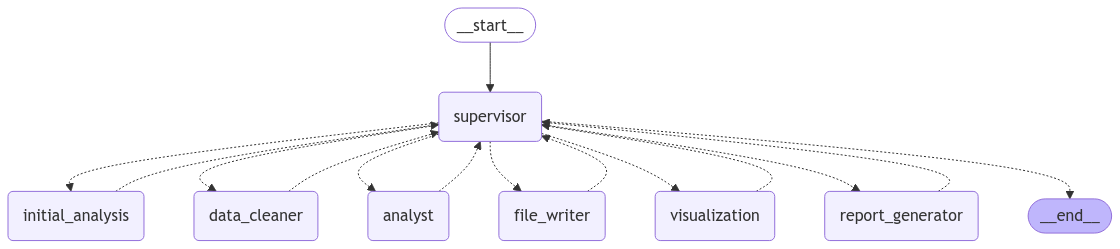

In [ ]:
from IPython.display import Image, display

display(Image(data_detective_graph.get_graph().draw_mermaid_png()))

In [ ]:

received = []

# initial_analysis_agent.get_state_history(config)
sample_prompt_final = HumanMessage(content=sample_prompt[1], name="user")

# try:
for s in data_detective_graph.stream({"messages": [sample_prompt_final], "user_prompt":sample_prompt[1],"_config":config, "df_ids":[df_id]},config,stream_mode="updates",subgraphs=True, debug=False):
  # pprint(f"State: {s}/n/n")
  pprint(s)
  print("\n")
  # print(f"Current State: {data_detective_graph.get_state(config)}")
  # if "supervisor" in s[1]:
  #   message = s[1]["supervisor"]["messages"][-1]
  #   if isinstance(message, tuple):
  #     pprint(f"Message: {message[1]}")
  #     received.append(message)
  #   else:
  #     pprint(f"Message: /n")
  #     message.pretty_print()
  #     received.append(message)
  # else:
  #   # if isinstance(s[1], ToolMessage) or isinstance(s[1], ToolMessageChunk) or isinstance(s[1], ToolCall):
  #     pprint(f"Message: {s[1]}")
  #     received.append(s[1])
    # else:
    #   continue
    # pprint(f"Skipping state as 'supervisor' is not present in s[1]. Current subgraph: {list(s[1].keys())[0]}")
    # pprint(f"Message: {s[1]}")
    # received.append(s[1])
  # pprint(s)
# except Exception as e:
  # pprint(f"Error: {e}")
  # pprint(f"Messages received: {received}")
  # pprint(f"Current State: {data_detective_graph.get_state(config)}")
  # pprint(e)
pprint(list(data_detective_graph.get_state_history(config)))

Coordinator node: current state keys: dict_keys(['messages', 'user_prompt', 'df_ids', '_config', 'is_last_step', 'remaining_steps', '_count_']). Current count: 1
/n Coordinator node: update_dict: {'next': 'initial_analysis', 'user_prompt': 'Please analyze the dataset named Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products You have tools available to you for accessing the data using the following str as the df_id parameter: `Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products`.', 'messages': [HumanMessage(content='Please analyze the dataset named Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products You have tools available to you for accessing the data using the following str as the df_id parameter: `Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products`.', additional_kwargs={}, response_metadata={}, name='user', id='0ba1db10-9b09-4b2c-b3e5-ca3697896ff4')]} and goto: initial_analysis /n
((),
 {'supervisor': {'messages': [HumanMessage(content='Please analyze the dataset named Data

BadRequestError: Error code: 400 - {'error': {'message': "Invalid schema for function 'GetData': [{'type': 'integer'}, {'type': 'string'}] is not of type 'object', 'boolean'.", 'type': 'invalid_request_error', 'param': 'tools[5].function.parameters', 'code': 'invalid_function_parameters'}}

In [ ]:
    last_state = data_detective_graph.get_state(config)

    print("\n")
    pprint(f"Analyst result summary: {last_state[0]['analysis_insights'].summary}")
    print("\n")
    pprint(f"Analyst result correlation_insights: {last_state[0]['analysis_insights'].correlation_insights}")
    print("\n")

    pprint(f"Analyst result anomaly_insights: {last_state[0]['analysis_insights'].anomaly_insights}")
    print("\n")

    pprint(f"Analyst result recommended_visualizations: {last_state[0]['analysis_insights'].recommended_visualizations}")

In [ ]:
from functools import cache
from io import BytesIO
from google.colab import drive

import ipywidgets as widgets
from IPython.display import display, clear_output

In [ ]:
# Testing Pydantic v2 model_validator migration and behavior
from pydantic import ValidationError

# Valid cases
print(GetDataParams(df_id='test', index=0, columns='all'))
print(GetDataParams(df_id='test', index=[0,1], columns='all'))
print(GetDataParams(df_id='test', index=(0,2), columns='all'))

# Invalid cases to confirm ValidationError
for invalid in ['invalid', (1,), [1,'a']]:
    try:
        GetDataParams(df_id='test', index=invalid, columns='all')
    except ValidationError as e:
        print(f"Caught expected ValidationError for index={invalid}: {e}")